## **Data characteristics**
In this file, the steps to determine various data characteristics are coded. 

### Dataset summary

In [1]:
# Run this to use from colab environment
import zipfile
import os
import pandas as pd
import numpy as np

#with zipfile.ZipFile('ecg_data.zip', 'r') as zip_ref: 
#    zip_ref.extractall('ecg')

data = pd.read_csv('ecg/ecg_data.csv', index_col=0)

# Preview/summary of the data
print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')
print(data.head())

# Converting to features and labels
features = data.drop(columns=['label'])
labels = data['label']

# Count the distribution of labels
label_counts = labels.value_counts()
label_percentages = label_counts / len(labels) * 100
label_distribution = pd.DataFrame({
    'Count': label_counts,
    'Percentage (%)': label_percentages.round(2)
})
print("\nLabel distribution:")
print(label_distribution)

# Checking for missing and infinite values
print("Total missing values:", features.isnull().sum().sum())
print("Total infinite values:", np.isinf(features.to_numpy()).sum())

The number of samples: 827
The number of columns: 9001
          0_0         0_1         0_2        0_3        0_4         0_5  \
0   47.685046   48.416904   37.371002  61.604757  58.732738  213.067966   
1  152.726718  297.353726  111.168880  25.419423  14.636085   24.609688   
2    1.601260    3.882169   22.978997  21.673040   8.919484   18.329286   
3    1.388947    3.052483    3.084103   4.627886  10.016196   15.020347   
4    3.625561    3.728466    6.205367  17.722897   5.699401    9.024836   

          0_6         0_7         0_8         0_9  ...    11_741    11_742  \
0  120.890451   40.100639   19.106303    6.043738  ...  0.078753  0.379885   
1   49.533842  253.651571  483.852043  167.617409  ...  0.804160  0.809705   
2   27.710604   23.350084   37.896254    8.331180  ...  0.156080  0.102070   
3  139.823127   20.149108   10.393109    9.241921  ...  0.238274  0.096733   
4   15.782812   33.336480   55.257804   19.139128  ...  0.056914  0.059116   

     11_743    11_744    

### Feature distribution

The magnitude of the feature values for each lead are visalized in the plots below to examine feature distribution/patterns in the data.

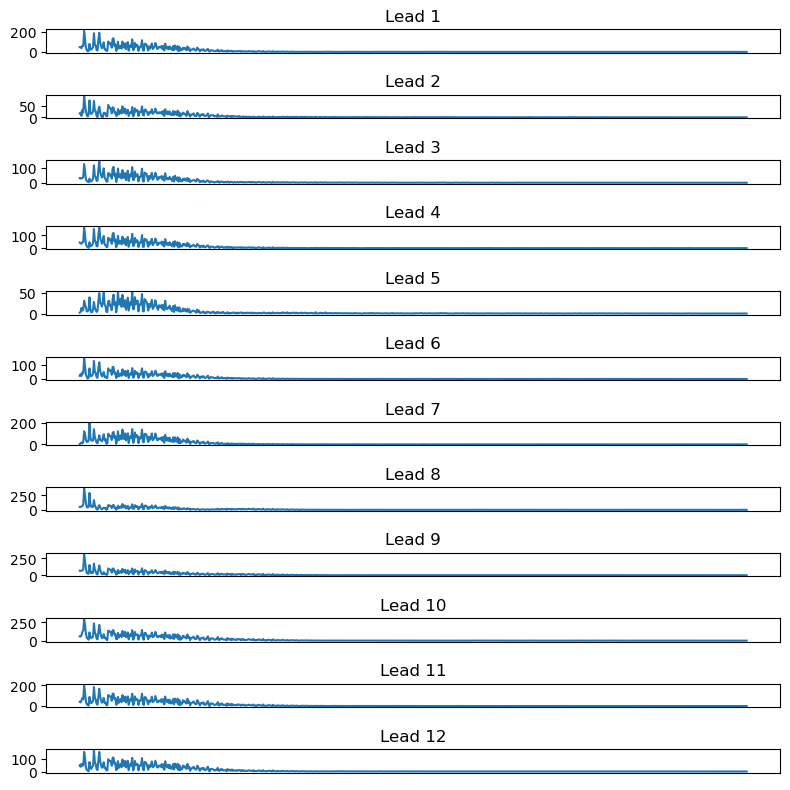

In [2]:
import matplotlib.pyplot as plt

# Select the first row (single ECG waveform)
sample_number = 0  # Index of the sample to visualize, use 0 for a normal ECG and 1 for an abnormal ECG 
#(as the first sample is normal and the second abnormal)
sample_ecg = data.iloc[sample_number, :-1]  # Select first row (first ECG signal) and exclude label

num_leads = 12
lead_size = 750

fig, axes = plt.subplots(num_leads, 1, figsize=(8, 8))
axes = axes.flatten()

# Loop through each lead
for i, ax in enumerate(axes):
    lead_start = i * lead_size       # Calculate the start index of the lead
    lead_end = (i + 1) * lead_size  # Calculate the end index of the lead
    lead = sample_ecg[lead_start:lead_end]  # Extract the lead data

    ax.plot(lead)  # Plot the lead
    ax.set_title(f'Lead {i+1}')  # Add title

    # Remove x-axis ticks and labels
    ax.set_xticks([])
    ax.set_xticklabels([])

plt.tight_layout()  # Adjust the subplots to fit into the figure
plt.show()


### Feature correlation

To investigate relationships between features, a correlation matrix was computed.

In [ ]:
# Caculate the correlation matrix
subset_of_features = features  
correlation_matrix = subset_of_features.corr()

#Identify highly correlated features
threshold = 0.95
upper = correlation_matrix.where( 
    np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool)) #only upper triangle of the matrix (to avoid checking each pair twice)

to_drop = set()
for column in upper.columns:
    high_corr = upper[column][abs(upper[column]) > threshold].index.tolist() # checks for correlation above the threshold
    for correlated_feature in high_corr:
        if correlated_feature not in to_drop and column not in to_drop:
            to_drop.add(correlated_feature)

print(f"Number of features with correlation to drop (one per correlated pair for which correlation > {threshold}): {len(to_drop)}")

# Drop redundant features
subset_of_features_reduced = subset_of_features.drop(columns=to_drop)
print(f"Number of features that remain: {len(subset_of_features_reduced.columns)}")


Number of features with correlation to drop (one per correlated pair for which correlation > 0.95): 4769
Number of features that remain: 4231
Classification Report:
              precision    recall  f1-score   support

           0       0.84      1.00      0.91       109
           1       1.00      0.12      0.22        24

    accuracy                           0.84       133
   macro avg       0.92      0.56      0.57       133
weighted avg       0.87      0.84      0.79       133


Confusion Matrix:
[[109   0]
 [ 21   3]]

ROC AUC Score: 0.8398318042813455


### Data (non-)linearity
To determine data linearity, PCA is performed. Before this analysis, the data is first split in a train and test set, using a 80-20 stratified split. Next, PCA is performed and the results are plotted in a scatter plot.

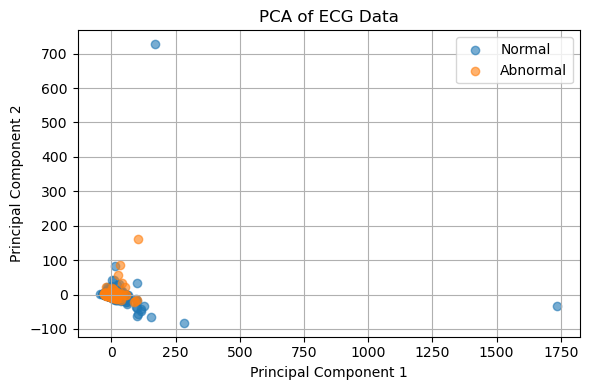

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Standardize the features, This is important for PCA as it relies on distances between points
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Perform PCA
pca = PCA(n_components=2) #reduce to 2 components for visualization
features_pca = pca.fit_transform(features_scaled)

# Plotting results
plt.figure(figsize=(6, 4))
plt.scatter(features_pca[labels.values == 0, 0], features_pca[labels.values == 0, 1], label='Normal', alpha=0.6)
plt.scatter(features_pca[labels.values == 1, 0], features_pca[labels.values == 1, 1], label='Abnormal', alpha=0.6)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of ECG Data')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Besides PCA, a covariance matrix was computed for each class and the mean absolute difference between covariance matrices was calculated to further determine data linearity. 

In [ ]:
# Split the data by class
class0 = data[data['label'] == 0]
class1 = data[data['label'] == 1]

# Compute covariance matrices for each class based on the 9000 features
n_features = 9000
cov0 = np.cov(class0.iloc[:, :n_features], rowvar=False)
cov1 = np.cov(class1.iloc[:, :n_features], rowvar=False)

# Calculate mean absolute difference between the covariance matrices
cov_diff = np.abs(cov0 - cov1)
print(f"Mean absolute difference between covariance matrices: {np.mean(cov_diff)}")


Mean absolute difference between covariance matrices: 32.98255583485797
